<a href="https://colab.research.google.com/github/juandarango/Machine_Learning_Vorlesung/blob/main/DS_ML_PL_Notebook_V07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Einführung in fastai mit google Colab
*Quelle: https://course.fast.ai/start_colab und https://docs.fast.ai/tutorial.vision.html*


Vor dem Ausführen muss Colab mitgeteilt werden, dass man eine GPU als Hardwarebeschleunigung benutzen möchte. Hierzu klickt man auf den Tab "Laufzeit" und wählt "Laufzeittyp ändern" aus. Es öffnet sich ein entsprechendes Pop-up-Fenster mit einem Drop-Down-Menü.
Hier kann GPU ausgewählt werden.









Graphics Processing Unit (GPU): Auch bekannt als _Grafikprozessor_ ist ein spezieller computer-Prozessor der tausende Einzelprozesse zur gleichen Zeit verarbeiten kann. Sie kommen speziell bei der Darstellung von dreidimensionalen Umgebungen und Computerspielen zum Einsatz, was berechnungstechnich einen ähnlich Aufwand darstellt, wie die Arbeit eines neuronalen Netzwerks. Deswegen können neuronale Netze GPUs hundert mal schneller betreiben als konventionelle CPUs. Hinzufügen muss man, dass alle modernen Computer über eine GPU verfügen, jedoch nicht alle für das "deep learning" geeignet sind.

# Die Konfiguration von fastai:

Falls es in der nächsten Zelle Probleme mit der Version von torchtext gibt: (ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible), einfach weiter machen.

In [26]:
# Das Buch installiert fastai und hat auch hilfreiche Funktionen
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
# Sollte es hier oder im Folgenden zu nicht schlüssigen Fehlermeldungen kommen
# wie z.B. "ModuleNotFoundError" (obwohl installiert...),
# => Laufzeit -> Laufzeit neu starten
# Colab wird bei Inaktivität die Verbindung beenden und diese muss wieder neu
# aufgenommen werden.
# Nach dem fastai installiert ist fragt colab nach einem Zugangscode 
#  -> Link klicken -> Konto auswählen -> Link kopieren und in colab einfugen  

 Das Ausführen der einzelnen Zellen kann entweder über einen Klick auf den Play-Button links erfolgen, oder durch die Tastenkombination "Strg + Enter"

In [5]:
import torch
print(torch.__version__) 

1.6.0


In [6]:
import fastai
print(fastai.__version__ ) #soll > als 2.0 sein


2.0.16


# Computer vision

> Die fastai-Bibliothek für "Computer vision" verwenden.

In [7]:
from fastai.vision.all import *

Der Schwerpunkt in diesem Tutorial liegt auf dem schnellen Erstellen eines `Learner` und der Feinjustierung von vortrainierten Modellen für Computer-Vision-Anwendungen. Es basiert auf: https://docs.fast.ai/tutorial.vision.html

## Single-label classification

Für diese Anwendung verwenden wir das [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). 
Es beinhaltet die Bilder von 37 verschiedenen Katzen- und Hunderassen. Als erstes betrachten wir, einen simplen "cat-vs-dog classifier", der eine Klassifizierung der Unterschiede zwischen Hunden und Katzen vornimmt. Anschließend eine etwas vortgeschrittenere Version, welche auch die unterschiedlichen Rassen klassifizieren kann.
Das Dataset kann mit der folgenden Codezeile heruntergeladen und entpackt werden:

In [8]:
path = untar_data(URLs.PETS)
path

Path('/home/ara/.fastai/data/oxford-iiit-pet')

Der Download wird nur einmal ausgeführt und der Speicherort der entpackten Datei angezeigt werden. Den Inhalt kann man mit der `.ls()`-Methode überprüft werden.

In [9]:
path.ls()

(#3) [Path('/home/ara/.fastai/data/oxford-iiit-pet/models'),Path('/home/ara/.fastai/data/oxford-iiit-pet/annotations'),Path('/home/ara/.fastai/data/oxford-iiit-pet/images')]

Der Fokus liegt nun auf dem Images-Ordner und der Anmerkungen(annotations)-Ordner wird zunächst noch ignoriert. `get_image_files` ist eine fastai-Funktion, die es ermöglicht, alle Bilddateien in einem Ordner zu erfassen (auch rekursiv).

In [10]:
files = get_image_files(path/"images")
len(files)

7390

### Cats vs dogs

Um die Daten des Katzen vs. Hunde Problems zuordnen zu können, muss zunächst bekannt sein, welche Dateien Hunde- oder Katzenbilderenthalten. Hierzu müssen die Anfangsbuchstaben der jeweiligen Dateinamen beachtet werden. Hundebilder haben einen kleinen Anfangsbuchstaben und Katzenbilder einen großen Anfangsbuchstaben:

In [11]:
files.sort()
files[0],files[6000]

(Path('/home/ara/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg'),
 Path('/home/ara/.fastai/data/oxford-iiit-pet/images/saint_bernard_1.jpg'))

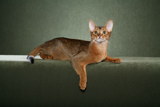

In [12]:
im_0 = PILImage.create(files[0])
im_6 = PILImage.create(files[6000])
im_0.to_thumb(160)

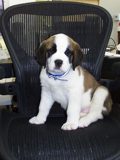

In [13]:
im_6.to_thumb(160)

In [14]:
files[0].name, files[6000].name

('Abyssinian_1.jpg', 'saint_bernard_1.jpg')

Es kann eine einfache Beschriftungsfunktion definiert werden:

In [15]:
def label_func(f): return f[0].isupper() # Ist der erste Buchstabe einer Großbuchstabe bzw. eine Katze? 

label_func(files[6000].name)


False

### DataLoaders in fastai: Daten Vorbereitung für das Model
Um die Daten nun für ein Modell fertigzustellen, müssen sie in ein `DataLoaders`-Objekt überführt werden. Hierfür wird die Funktion `ImageDataLoaders.from_name_func`verwendet, die mittels der Dateibezeichnungen Namen vergibt. Es existieren auch weitere Entwurfsmuster von `ImageDataLoaders`, die passend wären diese Problemstellung zu lösen. Deswegen sollten in `vision.data` alle einmal durchgeschaut werden.

In [16]:
dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(224))


Diese Funktion verwendet den Ordner in dem gearbeitet wird, die Dateien, die als `files` definiert wurden, die definierte `label_func` Funktion und als letztes `item_tfms` als Variablen. Die letzte Variable,`Transform` bezeichnet, wird auf alle Items des Datensatzes angewandt und passt die Größe des jeweiligen Bildes auf 224 zu 224 an. Dazu wird das Bild an der größte Dimension zufällig um ein Quadrat zu erzeugen, dessen Größe nun auf die gewünschte Größe angepasst wird. Das Auslassen dieses Schrittes würde später in einer Fehlermeldung resultieren, weil es unmöglich wäre, die einzelnen Elemente zu stapeln.
Mit der `show_batch`-Methode kann überprüft werden, ob alles in Ordnung dargestellt wird. (`True` steht für Katzen und `False` für Hunde):

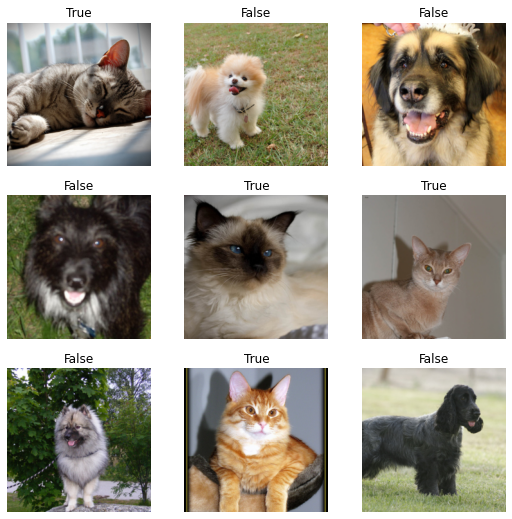

In [17]:
dls.show_batch()

### Zweite Option: DataBlock API

Nicht alle Datensätze haben eine Architektur, auf die man `ImageDataLoaders.from_name_func` anwenden kann.
Die DataBlock API lässt uns den `DataLoader` flexibler gestalten 

Gibt man der fastai-Bibliothek einige Informationen, kann man einen DataBlock erstellen:
- Die verwendeten Typen durch das Argument `blocks`: Hier werden Images und Kategorien benötigt, also: `ImageBlock` und `CategoryBlock` als tuple (Input,Output)
- die Quelle der unverarbeiteten Elemente, hier: `get_image_files`
- wie diese Elemente benannt werden sollen, hier mit einer modifizierten `label_func`-Funktion: `get_y`
- wie diese Elemente aufgeteilt werden soll, hier mit einem Zufallssplitter
- schließlich wie bereits vorher schon: `item_tfms` 

In [18]:
def get_y(f): 
  f = f.name
  return f[0].isupper()

print(files[0])
get_y(files[0])

/home/ara/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg


True

In [16]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=get_y,
                 item_tfms=Resize(224),
                )

Das Objekt "Pets" ist von sich aus leer: Es enthällt nur die Funktionen, die nützlich sind um die Daten zu sammeln. Das verwenden der `dataloaders`-Methode erzeugt einen `DataLoaders`. Als Argument wird der Pfad angegeben, an welchem sich die Bilder befinden:

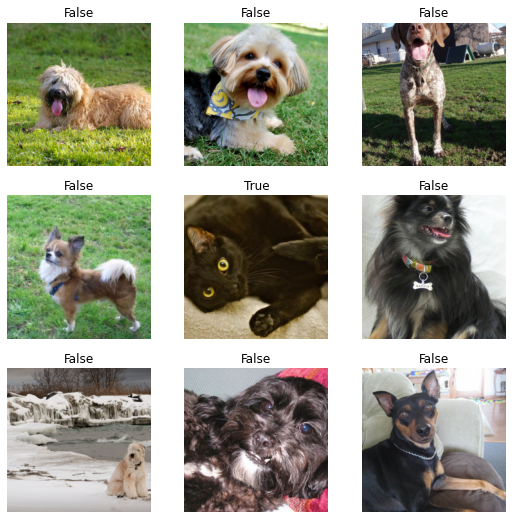

In [17]:
pets_dls = pets.dataloaders(path/"images")
pets_dls.show_batch()

### Das Learner Objekt:

Nun kann ein `Learner` erstellt werden. Hierbei handelt es sich um ein fastai-Objekt, welches die Daten und ein Modell zum trainieren kombiniert und Transferlernen zur Feinjustierung verwendet und das mit nur zwei Zeilen Code:

In [19]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

In der ersten Zeile wird ein Modell names ResNet34 heruntergeladen, welches bereits auf [ImageNet](http://www.image-net.org/) vortrainiert und auf die hiesige Problematik angepasst wurde. Anschließend wird das Feintuning vorgenommen und nach einer relativ kurzen Zeit haben wir ein Modell mit einer Fehlerrate von unter **5%** ... großartig!
Möchte man nun selber eine Prognose zu einem neuen Bild stelle, kann man einfach `learn.predict` verwenden:

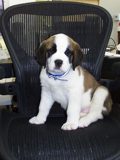

In [20]:
im_6.to_thumb(160)

In [21]:
is_cat,class_index,probs = learn.predict(im_6)
print(f"Is this a cat?: {is_cat}.")
print(f"Probability it's a cat: {probs[1].item():.6f}")

Is this a cat?: False.
Probability it's a cat: 0.000001


In [22]:
learn.predict(im_6)

('False', tensor(0), tensor([1.0000e+00, 1.0809e-06]))

Die Methode kann drei Dinge ausgeben: Die dekodierte Voraussage (hier `False` für Hunde), den Index der vorausgesagten Klasse und den Tensor der Wahrscheinlichkeiten aller Klassen in der Reihenfolge ihrer indizierten Bezeichnungen [Hund Wahrscheinlichkeit, Katze Wahrscheinlichkeit]  (in diesem Fall scheint das Modell sich ziemlich sicher zu sein, dass es ein Hund ist). Diese Methode akzeptiert einen Dateinamen, ein PIL-Image oder direkt einen Tensor. Mit der `show_results`-Methode können wir uns auch direkt einige Vorhersagen anzeigen lassen:

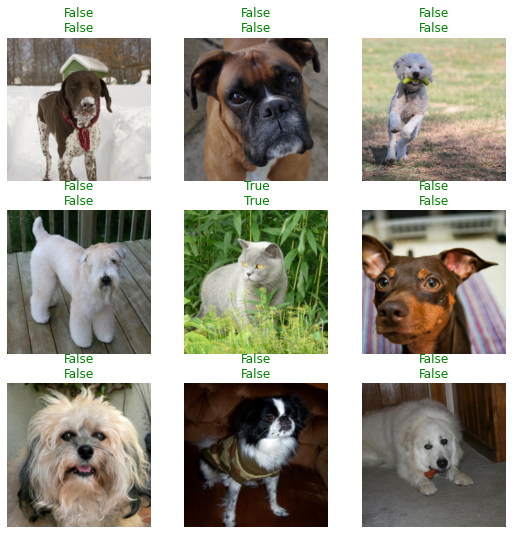

In [23]:
learn.show_results()

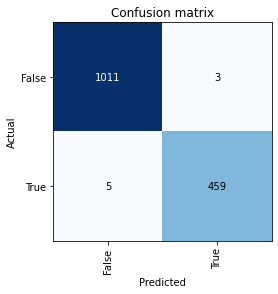

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Versuchen Sie es mit einem eigenem Bild



In [28]:
uploader = widgets.FileUpload()
uploader
# auf Upload clicken und ein Bild auswählen

FileUpload(value={}, description='Upload')

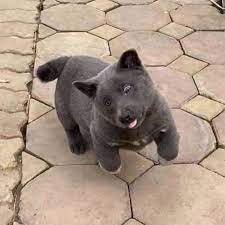

In [29]:
img = PILImage.create(uploader.data[0])
img

In [30]:
is_cat,_,probs = learn.predict(img)
print(f"Is this a cat?: {is_cat}.")
print(f"Probability it's a cat: {probs[1].item():.6f}")

Is this a cat?: False.
Probability it's a cat: 0.202537


## Rassen klassifizieren

Um unsere Dateien den Namen der entsprechenden Rasse anzuhängen, verwenden wir einen regulären Ausdruck. Schauen wir uns nochmal die Dateinamen an:

In [32]:
files[0].name

'Abyssinian_1.jpg'

also ist die Klasse die Bezeichnung, die vor dem letzten `_`steht, gefolgt von einigen Ziffern. Der reguläre Ausdruck, um den Namen zu erhalten, sieht wie folgt aus:

In [33]:
pat = r'^(.*)_\d+.jpg'

RegEx Erklärung: https://medium.com/@jamestjw/parsing-file-names-using-regular-expressions-3e85d64deb69 und https://docs.python.org/3/library/re.html 

Da es recht offen vorkommt, einen regulären Ausdruck zum labeln der Daten zu verwenden (Labels verstecken sich oft in den Dateinamen), gibt es ein Entwurfsmuster, um genau dies zu tun:

In [34]:
dls = ImageDataLoaders.from_name_re(path, files, pat, item_tfms=Resize(224))

Wie bereits zuvor können wir `show_batch` verwenden, um unsere Daten zu betrachten:

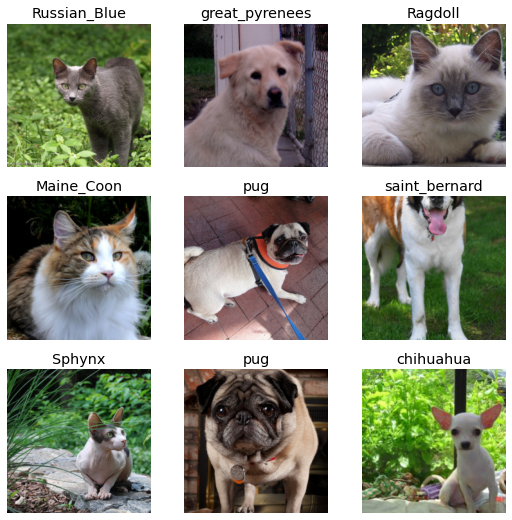

In [35]:
dls.show_batch()

Weil das exakte Klassifizieren der einen von 37 möglichen Rassen von Katzen und Hunden ein schwierigeres Problem darstellt, werden wir die Definition von `DataLoaders` leicht verändern um Datenerweiterungen (Data-Augmentation) zu verwenden:

In [36]:
dls = ImageDataLoaders.from_name_re(path, files, pat, item_tfms=Resize(460),
                                    batch_tfms=aug_transforms(size=224))

Dieses mal wurde vor dem Batching auf eine andere Größe zugeschnitten und es wurde `batch_tfms` hinzugefügt. `aug_transforms` ist eine Funktion die eine Sammlung an Datenerweiterungen zur Verfügung stellt, welche auf viele Datensätze angewendet werden können. Diese Transformationen können angepasst werden, indem entsprechende Argumente an `aug_transnforms` vergeben werden.
Das zufällige Beschneiden der Bilder soll bewirken, dass auch einzelne Bildabschnitte zur Bilderkennung ausreichen.

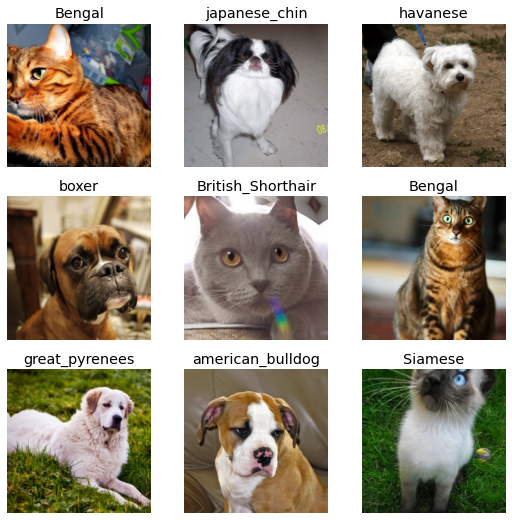

In [37]:
dls.show_batch()

Der `Learner` kann genauso wie vorher erstellt und das Modell trainiert werden.

In [38]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

Mehr über den Auswahl von epochen und learning_rate wird in kommenden Vorlesungen diskutiert

In [39]:
epoche = 2
learning_rate = 3e-3
learn.fine_tune(epoche, learning_rate)

Mit `show_results` schauen wir uns wieder einige Voraussagen an:

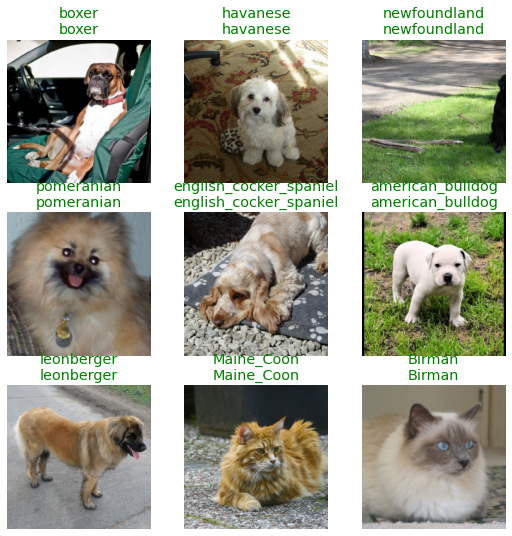

In [40]:
learn.show_results()

Eine weitere nützliche Information ist das sogenannte Interpretationsobjekt. Es zeigt an, wo das Modell die schlechteste Voraussage gemacht hat:

In [41]:
interp = ClassificationInterpretation.from_learner(learn)

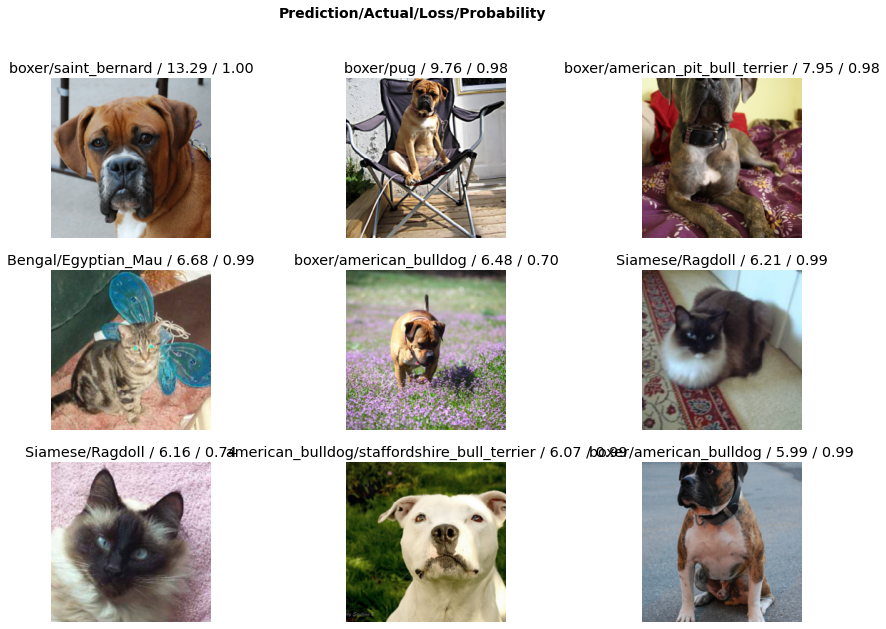

In [42]:
interp.plot_top_losses(9, figsize=(15,10))

# Transferlernen im Text

> Wie funktioniert die Feinjustierung eines Sprachmodell und wie kann man eine Klassifizierung trainieren.

In [43]:
from fastai.text.all import *

In diesem Tutorial werden wir sehen, wie wir ein Modell zur Textklassifizierung (basierend auf deren Segmente) trainieren können. Zunächst schauen wir uns an, wie wir das schnell in ein paar Zeilen bewerkstelligen können. Anschließend versuchen wir mit [ULMFit paper](https://arxiv.org/abs/1801.06146) Ergebnisse nach aktuellem Technikstand zu erzielen.
Wir werden die IMDb-Datenbank aus dem Paper [Learning Word Vectors for Sentiment Analysis](https://ai.stanford.edu/~amaas/data/sentiment/) verwenden, welche mehrere Tausend Filmrezensionen enthält.

## Textklassifikator eines vortrainierten Modells trainieren

Wir werden versuchen, einen Klassifikator mittels eines vortrainierten Modells zu trainieren (so ähnlich wie in [vision tutorial](http://docs.fast.ai/tutorial.vision)). Um unsere Datein vorzubereiten, verwenden wir als zunächst die "high-level API"

## Verwendung der high-level API

Die Daten können mit dem folgenden Befehl heruntergeladen und entpackt werden:

In [2]:
path = untar_data(URLs.IMDB)
path.ls()

(#7) [Path('/home/ara/.fastai/data/imdb/train'),Path('/home/ara/.fastai/data/imdb/tmp_lm'),Path('/home/ara/.fastai/data/imdb/test'),Path('/home/ara/.fastai/data/imdb/unsup'),Path('/home/ara/.fastai/data/imdb/tmp_clas'),Path('/home/ara/.fastai/data/imdb/imdb.vocab'),Path('/home/ara/.fastai/data/imdb/README')]

In [3]:
(path/'train').ls()

(#4) [Path('/home/ara/.fastai/data/imdb/train/labeledBow.feat'),Path('/home/ara/.fastai/data/imdb/train/neg'),Path('/home/ara/.fastai/data/imdb/train/unsupBow.feat'),Path('/home/ara/.fastai/data/imdb/train/pos')]

Die Daten folgen einer ImageNet-style Ordnung. Im train-Ordner haben wir zwei Unterordner: `pos` und `neg` (für positive und negative Bewertungen). Wir können alles mit der `TextDataLoaders.from_folder`- Method zusammentragen. Das einzige was spezifiziert werden muss, ist der Name des Validierungsordners, welcher "test" heißt (nicht "valid" wie standardmäßig festgelegt).

In [4]:
dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test',bs=32)

Wir können uns die Daten mit der `show_batch`-Method anschauen:

In [5]:
dls.show_batch(max_n=3)

Es ist zu sehen, dass die Bibliothek automatisch den Text verarbeitet hat, um sie dann in *tokens* aufzuteilen. Dabei werden einige spezielle tokens hinzugefügt:
- `xxbos` gibt den Anfang eines Textes an
- `xxmaj` gibt an, dass das nächste Wort großgeschrieben wird.

Nun kann ein für den Text passenden `Learner` in einer Zeile definiert werden:

In [6]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

Hier verwenden wir die [AWD LSTM](https://arxiv.org/abs/1708.02182)-Architektur, `drop_mult` ist ein Parameter, der die maximale Größe aller Ausgaben in dem Modell kontrolliert und wir verwenden `accuracy` um herauszufinden, wie gut es läuft. Anschließend können wir das Feintuning für unser Modell vornehmen:

In [7]:
learn.fine_tune(4, 1e-2)
# dauert etwas länger

Nicht schlecht! Um zu sehen, wie gut unser Modell arbeitet, verwenden wir die `show_results`-Methode:

In [23]:
learn.show_results(max_n=3)

Und wir können sehr leicht Vorhersagen über neue Texte treffen:

In [9]:
learn.predict("I really love that movie!")

('pos', tensor(1), tensor([9.9766e-04, 9.9900e-01]))

In [27]:
learn.predict("Bad movie!")

('neg', tensor(0), tensor([0.7171, 0.2829]))

In [21]:
learn.predict("That movie makes no sense and it is predictable")

('neg', tensor(0), tensor([0.5366, 0.4634]))

In [22]:
learn.predict("That movie makes no sense and it is predictable, but it is funny")

('pos', tensor(1), tensor([0.2888, 0.7112]))

Hier können wir sehen, dass das Modell die Bewertung als positiv eingestuft hat. Der zweite Teil des Ergebnisses ist der Index von "pos" in unserem Datenvokabular und der letzte Teil sind die Wahrscheinlichkeiten, die jeder Klasse zugeordnet sind. (99.1% für "pos" und 0.9% für "neg"). 
Nun seid ihr dran! Schreibt eure eigene kleine Filmrezension oder kopiert eine aus dem Internet, damit wir sehen können, was das Modell darüber denkt.

### Die DataBlock-API benutzen

Wir können auch die DataBlock-API verwenden, um unsere Daten in einem `DataLoaders` abzurufen. Dies ist etwas für bereits Fortgeschrittenere. Wenn du dich noch nicht bereit fühlst dich mit neuen APIs vertraut zu machen, kannst du diesen Abschnitt gerne auslassen. Ein DataBlock wird aufgebaut indem man der fastai-Bibliothek einige Informationen gibt:
- die verwendeten Typen werden durch ein Argument, welches `blocks` genannt wird eingebracht: Wir haben hier Bilder und Kategorien, also geben wir `TextBlock` and `CategoryBlock` an. Um die Bibliothek zu informieren, dass unsere Texte Dateien in einem Ordner sind, verwenden wir `from_folder`
- wie die unverarbeiteten Items erhalten werden, hier durch unsere Funktion `get_text_files`.
- wie diese Items benannt werden sollen, hier mit dem übergeordneten Ordner
- wie die Items aufgeteilt werden sollen, hier mit dem Ordner zwei Ebenen darüber

In [10]:
imdb = DataBlock(blocks=(TextBlock.from_folder(path), CategoryBlock),
                 get_items=get_text_files,
                 get_y=parent_label,
                 splitter=GrandparentSplitter(valid_name='test'))

Dies gibt nur eine Blaupause zum Zusammenstellen der Daten. Zum richtigen Erstellen benötigen wir die `dataloaders`-Methode:

In [11]:
dls = imdb.dataloaders(path)